In [1]:
import gymnasium as gym
from hiive.mdptoolbox import mdp, example
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [250]:
def plot_stats(obj, algo="", prob="", cutoff=None):
    
    if cutoff is None:
        stats_dict = obj.run_stats
    else:
        stats_dict = obj.run_stats[0:cutoff]
    
    iters, meanV, maxV, t = [], [], [], []
    for result in stats_dict:
        iters.append(result['Iteration'])
        meanV.append(result['Mean V'])
        maxV.append(result['Max V'])
        t.append(result['Time'])
    
    
    
    g = plt.plot(iters, meanV, label="Mean V")
    plt.title("Value Function by Iteration")
    plt.xlabel("Iterations")
    
    plt.plot(iters, maxV, label="Max V")
    leg = plt.legend()

    if algo != "":
        plt.savefig("./paper/figures/V_" + prob + "_" + algo + ".png", transparent = True, format='png')

        
def plot_error(obj, algo="", prob="", cutoff=None):
    
    if cutoff is None:
        stats_dict = obj.run_stats
    else:
        stats_dict = obj.run_stats[0:cutoff]
    
    iters, error = [], []
    for result in stats_dict:
        iters.append(result['Iteration'])
        error.append(result['Error'])
    
    avg_error = np.cumsum(error) /  np.arange(1,len(error)+1)
    
    g = plt.plot(iters, error, label="Error")
    plt.title("Error by Iteration")
    plt.xlabel("Iterations")
    #plt.plot(iters, avg_error, label="Average Error")
    leg = plt.legend()
    if algo != "":
        plt.savefig("./paper/figures/error_" + prob + "_" + algo + ".png", transparent = True, format='png')
        
def policy_viz(obj, prob="", algo="", vmax=1, vmin=-1):
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors
    policy = np.array([dirs[a] for a in obj.policy])
    V = np.array(obj.V)
    V[-1] = 1
    dims = int(len(V)**(0.5))
    V = np.reshape(V, (dims, dims))
    policy = np.reshape(policy, (dims, dims))
    V = np.round(V, 2)
    
    fig, ax = plt.subplots()
    # color centering adapted from https://stackoverflow.com/questions/69707509/seaborn-plot-with-colorbar-centered-around-0
    vcenter = 0
    normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
    colormap = cm.RdBu
    sns.heatmap(V, annot=policy, fmt = '', norm=normalize, cmap=colormap)
        
    if algo != "":
        plt.savefig("./paper/figures/policy_" + prob + "_" + algo + ".png", transparent = True, format='png')


## Frozen Lake

In [160]:
def make_lake(size=20, seed=12345):

    np.random.seed(seed)
    lake = np.empty((size), dtype='<U' + str(size))
    row = np.empty((1,size), dtype=str)
    for i in range(size):
        for j in range(size):
            row[0,j] = np.random.choice(('F','H'), size, p = [.9, .1])[0]
        lake[i] = np.array2string(row, separator='').replace("'","").replace('[',"").replace("]","")

    # set start and goal
    lake[0] = 'S' + lake[0][1:size]
    lake[(size-1)] = lake[(size-1)][0:(size-1)] + 'G'
    
    # identify the holes in the lake for reward shaping
    long_lake = np.array2string(lake, separator='').replace("'","").replace('[',"").replace("]","").replace("\n",'').replace(" ","")
    holes = []
    ct = 0
    for i in long_lake:
        if i == 'H':
            holes.append(ct)
        ct += 1
    
    return list(lake), holes


In [373]:
discount = .95
lake_args = {'desc':None,'map_name':"8x8",'is_slippery':True}
P, R = example.openai('FrozenLake-v1', **lake_args)
inits = np.random.random(P.shape[1]) / 100
dirs = {0:'<', 1:'v', 2:'>', 3:'^'}
R[[19, 29, 35, 41, 42, 46, 49, 50, 52, 59], :] = -.1

### Policy Iteration

In [374]:
pi = mdp.PolicyIteration(P, R, discount)
pi.run()
pi_dirs = [dirs[i] for i in pi.policy]

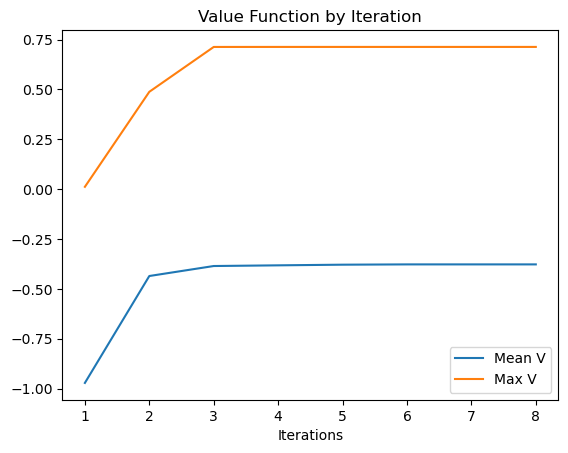

In [255]:
plot_stats(pi, cutoff=8, prob="8x8", algo="pi")

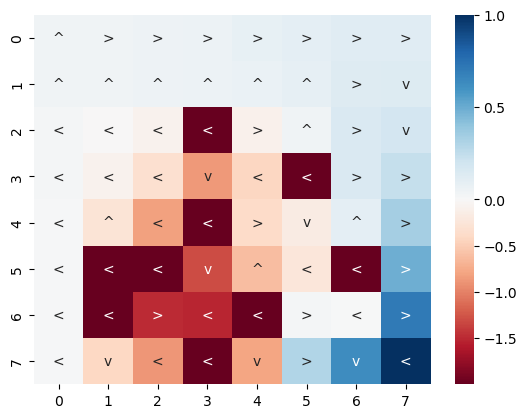

In [251]:
policy_viz(pi, prob="8x8", algo="pi", vmax=1, vmin=np.min(pi.V))

### Value Iteration

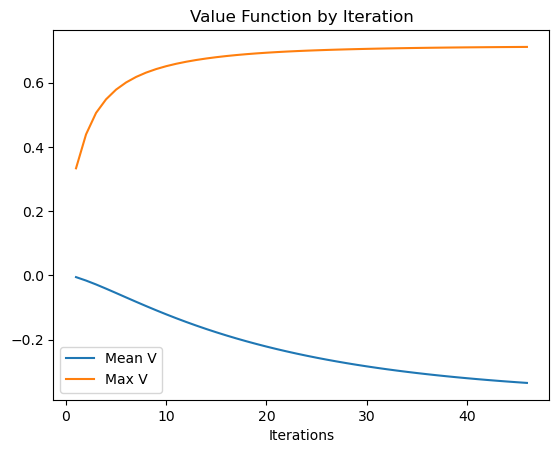

In [378]:
vi = mdp.ValueIteration(P, R, discount)
vi.run()
vi_dirs = [dirs[i] for i in vi.policy]
plot_stats(vi, prob="8x8", algo="vi")

## Q-learning

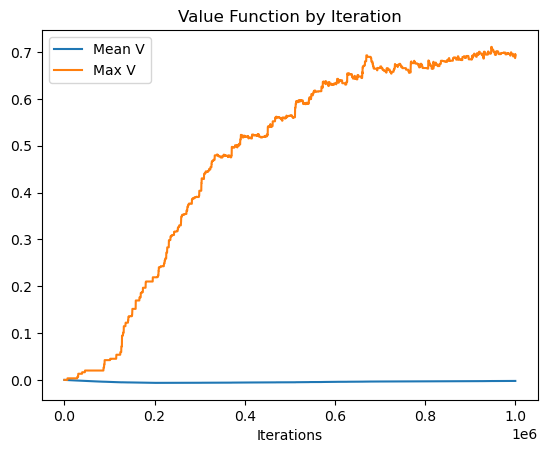

In [401]:
np.random.seed(123456)
n_iter = 1000000
alpha = 0.5
epsilon = 1.0
q_params = {'n_iter':n_iter,
            'alpha':alpha,
            'alpha_decay':.9,
            'alpha_min':0.01,
            'epsilon':epsilon,
            'epsilon_min':0,
            'epsilon_decay':0.99999}

ql = mdp.QLearning(P, R, discount, **q_params)
ql.run()
ql_dirs = [dirs[i] for i in ql.policy]
plot_stats(ql, prob="8x8", algo="q")

In [ ]:
policy_viz(ql, prob="8x8", algo="q", vmax=1, vmin=np.min(ql.V))

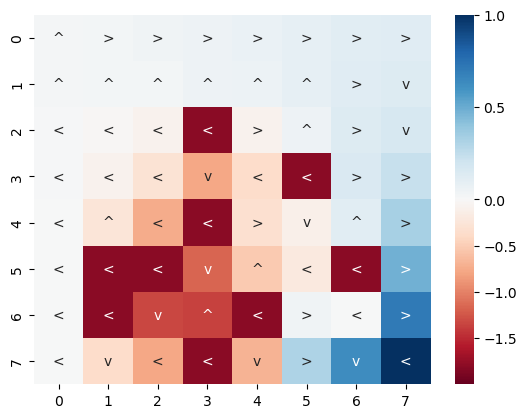

In [382]:
policy_viz(vi, prob="8x8", algo="q", vmax=1, vmin=np.min(ql.V))

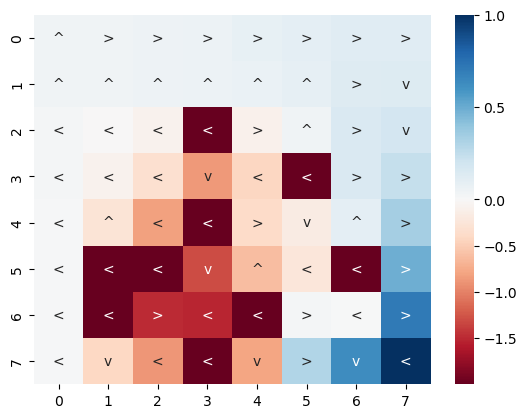

In [383]:
policy_viz(pi, prob="8x8", algo="q", vmax=1, vmin=np.min(ql.V))

In [433]:
def sim_lake(pol):
    np.random.seed(123456)
    iters = 10000
    rewards = np.zeros(iters)
    for i in range(iters):
        env = gym.make('FrozenLake-v1', **lake_args)
        observation, info = env.reset()
        terminated = False
        while not terminated:
            action = pol.policy[observation]
            observation, reward, terminated, truncated, info = env.step(action)
            if terminated:
                env.close()
                break
        rewards[i] = reward
    return rewards

In [434]:
sim_pi, sim_vi, sim_ql = sim_lake(pi), sim_lake(vi), sim_lake(ql)

In [435]:
sim_pi, sim_vi, sim_ql

(array([1., 1., 1., ..., 1., 1., 1.]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([1., 1., 1., ..., 1., 1., 1.]))

In [439]:
np.mean(sim_pi), np.mean(sim_vi), np.mean(sim_ql)

(0.9961, 0.9963, 0.9198)

### Big Lake

In [410]:
discount = .95
lake, holes = make_lake(20)
lake_args = {'desc':lake,'is_slippery':True}
P, R = example.openai('FrozenLake-v1', **lake_args)
inits = np.random.random(P.shape[1]) / 100
dirs = {0:'<', 1:'v', 2:'>', 3:'^'}
R[holes, :] = -.1

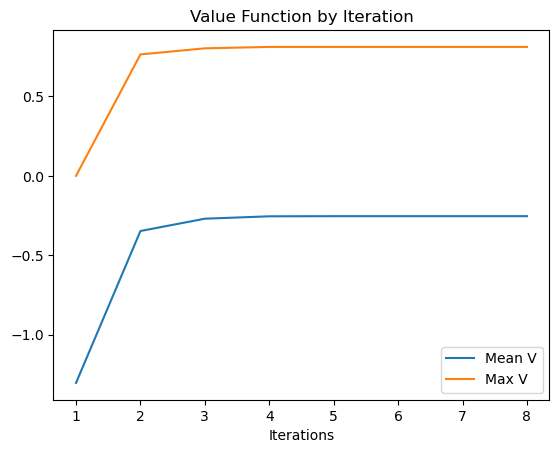

In [411]:
pi = mdp.PolicyIteration(P, R, discount)
pi.run()
pi_dirs = [dirs[i] for i in pi.policy]
plot_stats(pi, cutoff=8, prob="20x20", algo="pi")

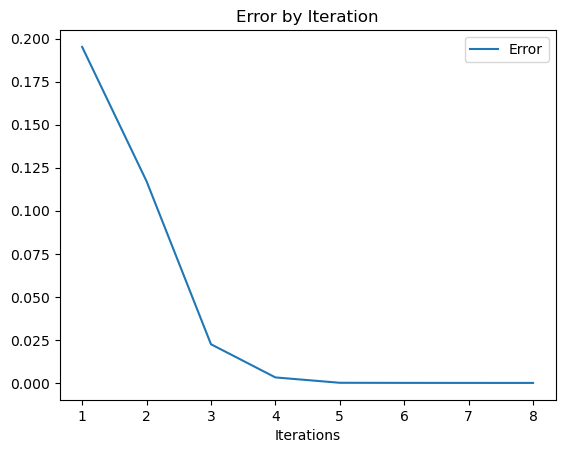

In [403]:
plot_error(pi, cutoff=8, prob="20x20", algo="pi")

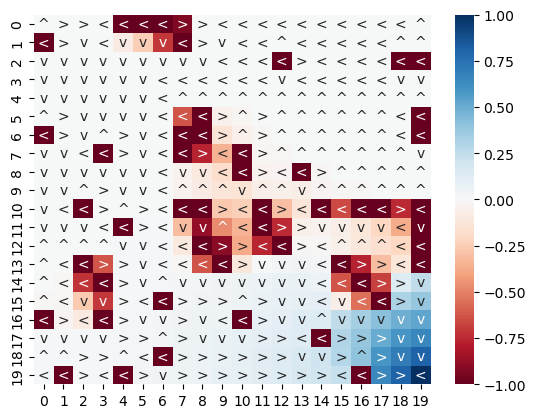

In [418]:
policy_viz(pi, prob="20x20", algo="pi")

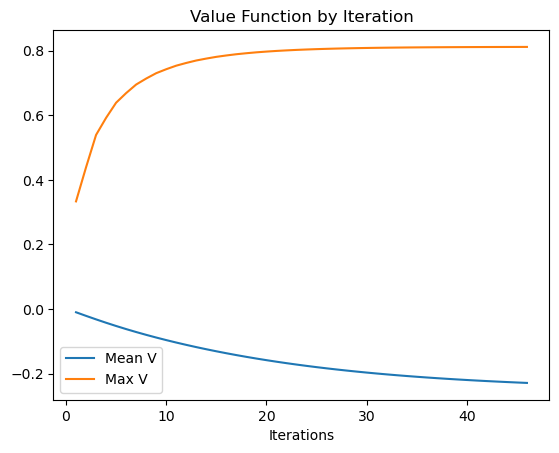

In [416]:
vi = mdp.ValueIteration(P, R, discount)
vi.run()
vi_dirs = [dirs[i] for i in vi.policy]
plot_stats(vi, prob="20x20", algo="vi")

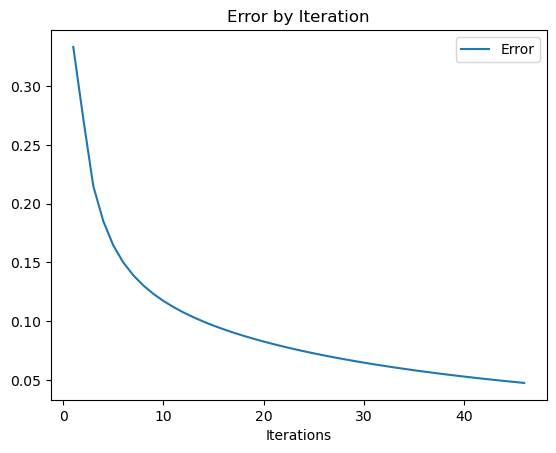

In [243]:
plot_error(vi, prob="20x20", algo="vi")

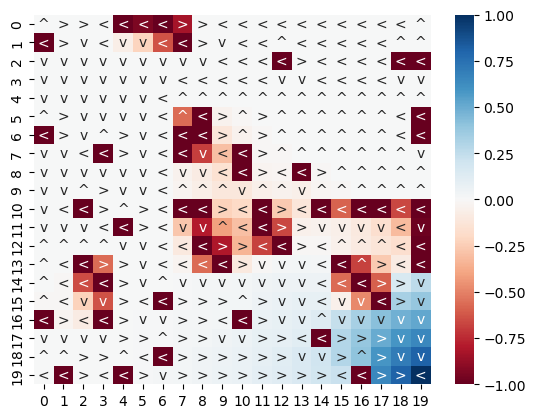

In [417]:
policy_viz(vi, prob="20x20", algo="vi")

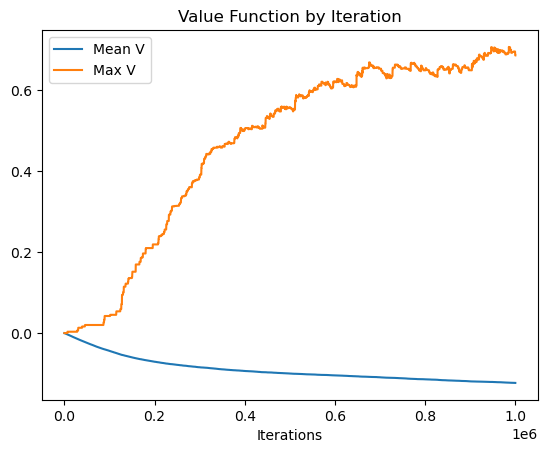

In [426]:
np.random.seed(123456)
n_iter = 1000000
alpha = 0.5
epsilon = 1.0
q_params = {'n_iter':n_iter,
            'alpha':alpha,
            'alpha_decay':.9,
            'alpha_min':0.01,
            'epsilon':epsilon,
            'epsilon_min':0,
            'epsilon_decay':0.99999}

ql = mdp.QLearning(P, R, discount, **q_params)
ql.run()
ql_dirs = [dirs[i] for i in ql.policy]
plot_stats(ql, prob="20x20", algo="q")

In [431]:
vi.run_stats[-1]

{'State': None,
 'Action': None,
 'Reward': 0.8118091438601376,
 'Error': 0.009944025698709336,
 'Time': 0.011587858200073242,
 'Max V': 0.8118091438601376,
 'Mean V': -0.22895942914521736,
 'Iteration': 46}

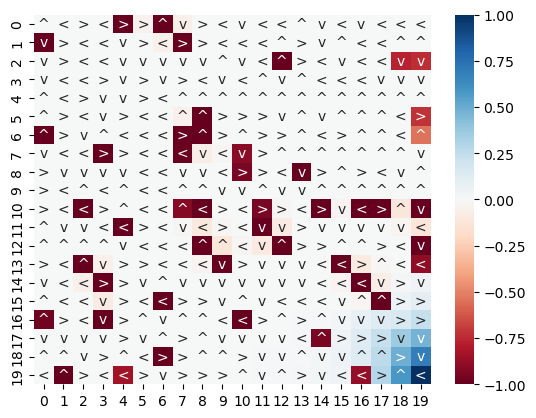

In [427]:
policy_viz(ql, prob="20x20", algo="q")

## Forest

In [454]:
forest_params={'S':10,'r1':4,'r2':2,'p':0.2}
discount = 0.96
P, R = example.forest(**forest_params)
vi = mdp.ValueIteration(P, R, discount)
vi.verbose = False
vi.run()
vi.policy

(0, 1, 0, 0, 0, 0, 0, 0, 0, 0)

In [448]:
pi = mdp.PolicyIteration(P, R, discount)
pi.verbose = False
pi.run()
pi.policy

(0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

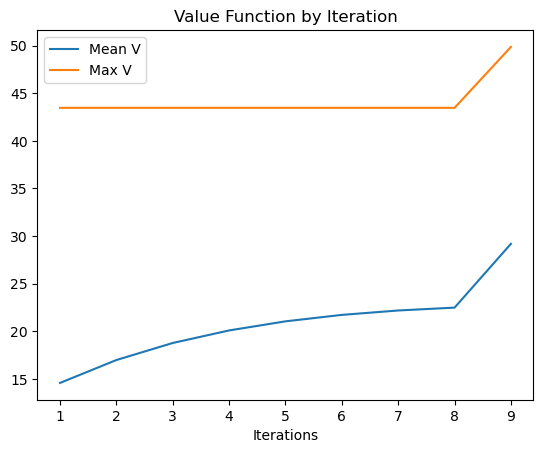

In [445]:
plot_stats(pi, prob="forest", algo="pi")

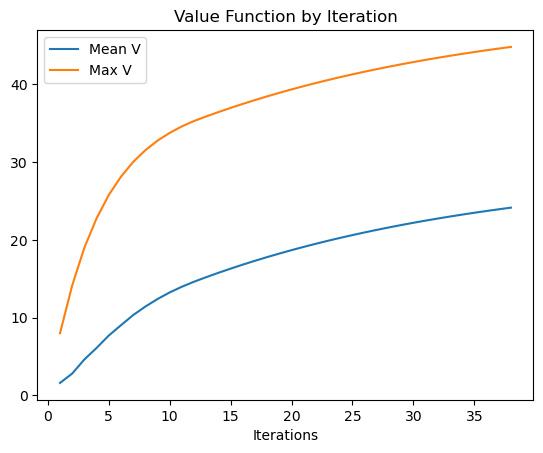

In [361]:
plot_stats(vi, prob="forest", algo="vi")

In [455]:
np.random.seed(12345)
n_iter = 10000000
alpha = 0.5
epsilon = 1.0
q_params = {'n_iter':n_iter,
            'alpha':alpha,
            'alpha_decay':.9999,
            'alpha_min':0.01,
            'epsilon':epsilon,
            'epsilon_min':0.1,
            'epsilon_decay':0.9999}

ql = mdp.QLearning(P, R, discount, **q_params)
ql.verbose = False
ql.run()
ql.policy

(0, 1, 0, 0, 0, 0, 0, 0, 0, 0)

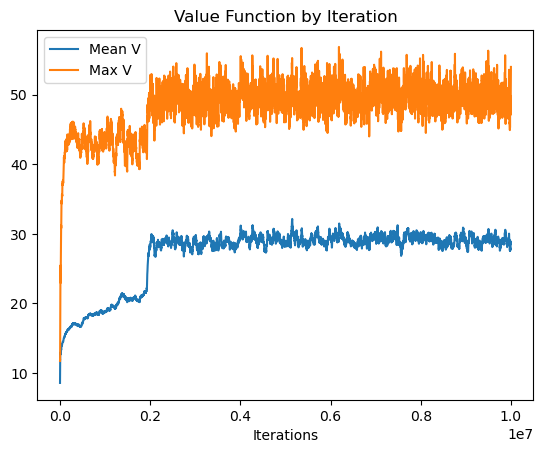

In [362]:
plot_stats(ql, prob="forest", algo="q")

In [368]:

def forest_sim(pol, delta, seed = 12345, iters=100):
    np.random.seed(seed)
    state = 0
    cumul_r = np.zeros(iters)
    cumul_d = np.zeros(iters)
    for i in range(iters):
        action = pol[state]
        r = R[state, action]
        #print(state, action, r)
        state = np.random.choice(len(pol), p=P[action,state])
        cumul_r[i] = delta**(i) * r
        cumul_d[i] = (i) * r
    return cumul_r, cumul_d


In [452]:
## Sub-optimal q-learning
np.random.seed(12345)
n_iter = 100000
alpha = 0.5
epsilon = 1.0
q_params = {'n_iter':n_iter,
            'alpha':alpha,
            'alpha_decay':.9999,
            'alpha_min':0.01,
            'epsilon':epsilon,
            'epsilon_min':0.1,
            'epsilon_decay':0.9999}

ql = mdp.QLearning(P, R, discount, **q_params)
ql.verbose = False
ql.run()
ql.policy

(0, 1, 1, 1, 1, 1, 1, 1, 0, 0)

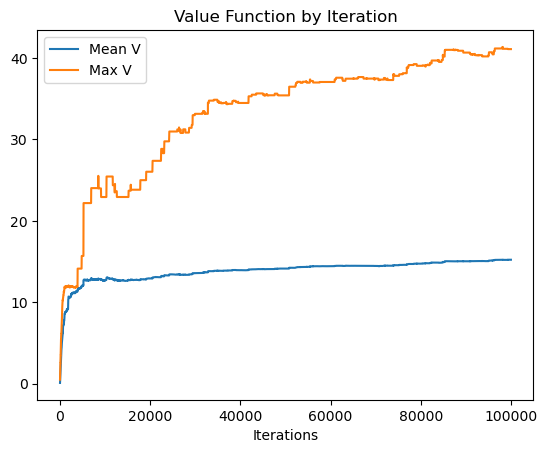

In [365]:
plot_stats(ql, prob="forest", algo="q_sub")

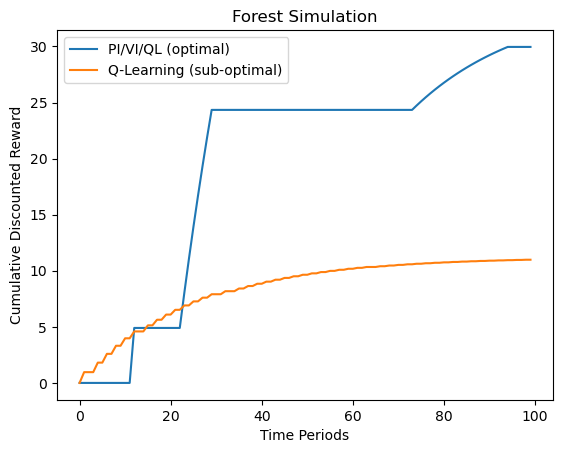

In [453]:
fig, ax = plt.subplots()
plt.plot(np.cumsum(forest_sim(pi.policy, discount)[0]), label="PI/VI/QL (optimal)")
plt.plot(np.cumsum(forest_sim(ql.policy, discount)[0]), label="Q-Learning (sub-optimal)")
plt.legend()
plt.xlabel("Time Periods")
plt.ylabel("Cumulative Discounted Reward")
plt.title("Forest Simulation")
plt.savefig("./paper/figures/forest_sim.png", format = 'png', transparent = True)